In [1]:
import numpy as np
import pandas as pd
import random
import xml.etree.ElementTree
import matplotlib
%matplotlib inline

In [2]:
ttk_train_2016_xml = xml.etree.ElementTree.parse('../data/tkk_train_2016.xml').getroot().getchildren()[1]
rows = []
for row_xml in ttk_train_2016_xml.getchildren():
    row = []
    for cell in row_xml.getchildren():
        row.append(cell.text)
    rows.append(row)

/home/ilya/.virtualenvs/nlp/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  if __name__ == '__main__':
/home/ilya/.virtualenvs/nlp/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  app.launch_new_instance()
/home/ilya/.virtualenvs/nlp/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


In [3]:
ttk_names = ['beeline', 'mts', 'megafon', 'tele2', 'rostelecom', 'komstar', 'skylink']
ttk_train_2016 = pd.DataFrame(rows, columns=['id', 'twitid', 'date', 'text'] + ttk_names)

In [4]:
ttk_train_2016.head()

,id,twitid,date,text,beeline,mts,megafon,tele2,rostelecom,komstar,skylink
0,1,492367588165680000,1406224555,"@mkomov Максим, Вашем письмо мы получили. Наши...",0,NULL,NULL,NULL,NULL,NULL,NULL
1,2,492369449912380000,1406224999,«Мегафон» стал владельцем 50% акций «Евросети»,NULL,NULL,0,NULL,NULL,NULL,NULL
2,3,492369715378290000,1406225062,RT @fuckkiev: “@EvaKobb: МТС Россия прислала ж...,NULL,-1,NULL,NULL,NULL,NULL,NULL
3,4,492369842205650000,1406225092,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехо...,NULL,1,NULL,NULL,NULL,NULL,NULL
4,5,492371322060950000,1406225445,"@parfenov1960 потому что МТС достало, а пчел н...",NULL,-1,NULL,NULL,NULL,NULL,NULL


In [5]:
ttk_train_2016.shape

(8643, 11)

In [6]:
for row in ttk_train_2016.text[:20]:
    print row

@mkomov Максим, Вашем письмо мы получили. Наши сотрудники свяжутся с Вами завтра и направят запрос инженерам для проверки. #билайн
«Мегафон» стал владельцем 50% акций «Евросети»
RT @fuckkiev: “@EvaKobb: МТС Россия прислала жителям Херсонщины сообщения, в которых обозвала украинцев фашистами? http://t.co/RbSesXlOUZ” …
ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехом МТС - Супер 0
@parfenov1960 потому что МТС достало, а пчел ненавижу с детства, как и их мёд!
RT @f_u_c_k_y_o_u_: Билайн интернет стал полным говном
На Дне города в Тюмени «МегаФон» разыграет смартфон за лучшее селфи
&amp;laquo;Ростелеком&amp;raquo; стал партнером всероссийского конкурса &amp;laquo;Поколение i&amp;raquo; на создание лучшего интернет-проекта для детей, о
RT @parfenov1960: Сотовый оператор Мегафон проводит конкурс с розыгрышем 50 iPhone 5s. Для участия нужно... http://t.co/8SZYFgjtMe
«МегаФон» поможет контролировать расходы на Интернет за границей
@parfenov1960 Фуфло эт ваш Мегафон.просит много,дает мало.
@vinyl

In [8]:
def uniform_sentiment(row):
    return np.unique(row).shape[0] == 2;
    
mask = ttk_train_2016[ttk_names].apply(uniform_sentiment, axis=1)
print ttk_train_2016.shape[0] - ttk_train_2016[mask].shape[0], 'сообщения из 9к+ имеют разную тональность для разных компаний.'

131 сообщения из 9к+ имеют разную тональность для разных компаний.


Поэтому можем не решать задачу object-oriented, а предсказывать тональность для всего твита.

In [9]:
def one_object(row):
    return row.value_counts()['NULL'] == len(ttk_names) - 1;

mask = ttk_train_2016[ttk_names].apply(one_object, axis=1)
print ttk_train_2016.shape[0] - ttk_train_2016[mask].shape[0], 'сообщений имеют более одного объекта'

435 сообщений имеют более одного объекта


Вариант 1ый: берём только твиты с одним видом тональности и для твитов с упоминанием нескольких компаний оставляем лишь одну копию сообщения/лейбла

In [10]:
def get_one_label(row):
    vals = list(np.unique(row))
    vals.remove('NULL')
    return vals[0] if len(vals) == 1 else np.nan

ttk_train_2016_copy = ttk_train_2016.copy()
ttk_train_2016_copy['label'] = ttk_train_2016_copy[ttk_names].apply(get_one_label, axis=1)
ttk_train_2016_copy = ttk_train_2016_copy[['id', 'text', 'label']]
ttk_train_2016_copy.head()

,id,text,label
0,1,"@mkomov Максим, Вашем письмо мы получили. Наши...",0
1,2,«Мегафон» стал владельцем 50% акций «Евросети»,0
2,3,RT @fuckkiev: “@EvaKobb: МТС Россия прислала ж...,-1
3,4,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехо...,1
4,5,"@parfenov1960 потому что МТС достало, а пчел н...",-1


Вариант 2ой: для каждого упоминания компании в твите создаём отдельный семпл с сообщением и соответствующим лейблом

In [11]:
def get_all_labels(row):
    vals = row.values
    vals = vals[vals != 'NULL']
    return ' '.join(vals)

ttk_train_2016_copy = ttk_train_2016.copy()
ttk_train_2016_copy['labels'] = ttk_train_2016_copy[ttk_names].apply(get_all_labels, axis=1)
ttk_train_2016_copy = ttk_train_2016_copy[['id', 'text', 'labels']]

lbs = ttk_train_2016_copy['labels'].str.split(' ').apply(pd.Series, 1).stack()
lbs.index = lbs.index.droplevel(-1)
lbs.name = 'label'
del ttk_train_2016_copy['labels']

ttk_train_2016_copy = ttk_train_2016_copy.join(lbs)
ttk_train_2016_copy.head()

,id,text,label
0,1,"@mkomov Максим, Вашем письмо мы получили. Наши...",0
1,2,«Мегафон» стал владельцем 50% акций «Евросети»,0
2,3,RT @fuckkiev: “@EvaKobb: МТС Россия прислала ж...,-1
3,4,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехо...,1
4,5,"@parfenov1960 потому что МТС достало, а пчел н...",-1


In [12]:
print ttk_train_2016_copy.shape
ttk_train_2016_copy.dropna(inplace=True)
print ttk_train_2016_copy.shape

(9209, 3)
(9209, 3)


Соотношение классов:

In [13]:
ttk_train_2016_copy.label.value_counts()

0     5213
-1    2611
1     1385
Name: label, dtype: int64

Распределение длин сообщений в символах.

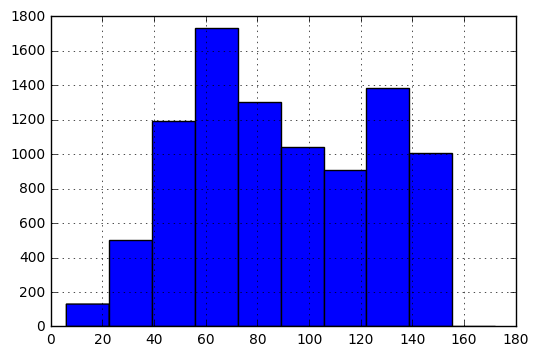

In [14]:
ttk_train_2016_copy.text.apply(len).hist()

Распределение длин сообщений в словах

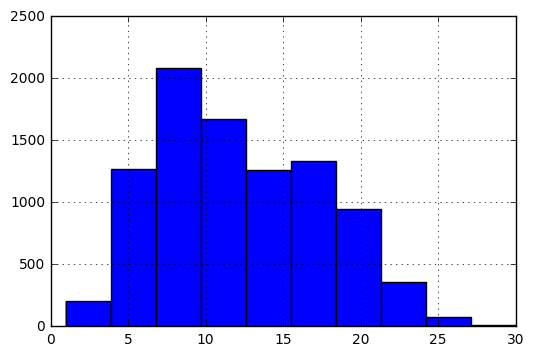

In [15]:
ttk_train_2016_copy.text.apply(lambda s: len(s.split())).hist()

In [16]:
ttk_train_2016_copy.to_csv('../data/ttk_train.csv', sep='\t', index=False, encoding='utf-8')

---

In [17]:
ttk_test_2016_xml = xml.etree.ElementTree.parse('../data/tkk_test_etalon.xml').getroot().getchildren()[1]
rows = []
for row_xml in ttk_test_2016_xml.getchildren():
    row = []
    for cell in row_xml.getchildren():
        row.append(cell.text)
    rows.append(row)

/home/ilya/.virtualenvs/nlp/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  if __name__ == '__main__':
/home/ilya/.virtualenvs/nlp/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  app.launch_new_instance()
/home/ilya/.virtualenvs/nlp/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


In [18]:
ttk_test_2016 = pd.DataFrame(rows, columns=['id', 'twitid', 'date', 'text'] + ttk_names)

In [19]:
ttk_test_2016.head()

,id,twitid,date,text,beeline,mts,megafon,tele2,rostelecom,komstar,skylink
0,1,615732055842910000,1435636936,RT vzglyad: По делу о работе МТС в Узбекистане...,NULL,-1,NULL,NULL,NULL,NULL,NULL
1,2,615732353806300000,1435637007,RT @kevinuyatukox: http://t.co/ljtrjq91v3 #Кре...,NULL,NULL,0,NULL,NULL,NULL,NULL
2,3,615733311873380000,1435637235,#Оформить кредитную карту в банке мтс http://t...,NULL,0,NULL,NULL,NULL,NULL,NULL
3,4,615734361116270000,1435637486,#Как перевести деньги с билайна на кредитную к...,0,NULL,NULL,NULL,NULL,NULL,NULL
4,5,615735339219610000,1435637719,#Начальник отдела кредитного контроля оао мтс ...,NULL,0,NULL,NULL,NULL,NULL,NULL


In [20]:
ttk_test_2016.shape

(2247, 11)

In [21]:
def get_all_labels(row):
    vals = row.values
    vals = vals[vals != 'NULL']
    return ' '.join(vals)

ttk_test_2016_copy = ttk_test_2016.copy()
ttk_test_2016_copy['labels'] = ttk_test_2016_copy[ttk_names].apply(get_all_labels, axis=1)
ttk_test_2016_copy = ttk_test_2016_copy[['id', 'text', 'labels']]

lbs = ttk_test_2016_copy['labels'].str.split(' ').apply(pd.Series, 1).stack()
lbs.index = lbs.index.droplevel(-1)
lbs.name = 'label'
del ttk_test_2016_copy['labels']

ttk_test_2016_copy = ttk_test_2016_copy.join(lbs)
ttk_test_2016_copy.head()

,id,text,label
0,1,RT vzglyad: По делу о работе МТС в Узбекистане...,-1
1,2,RT @kevinuyatukox: http://t.co/ljtrjq91v3 #Кре...,0
2,3,#Оформить кредитную карту в банке мтс http://t...,0
3,4,#Как перевести деньги с билайна на кредитную к...,0
4,5,#Начальник отдела кредитного контроля оао мтс ...,0


In [22]:
print ttk_test_2016_copy.shape
ttk_test_2016_copy.dropna(inplace=True)
print ttk_test_2016_copy.shape

(2460, 3)
(2460, 3)


In [23]:
ttk_test_2016_copy.label.value_counts()

-1    1167
0     1062
1      231
Name: label, dtype: int64

In [24]:
ttk_test_2016_copy.to_csv('../data/ttk_test.csv', sep='\t', index=False, encoding='utf-8')